# Курс "Практикум по математической статистике"
# 3 курс ФПМИ МФТИ, осень 2025
## Практическое задание 5. Байесовские методы.
### Дедлайн --- 13 декабря 16:00

Это обязательное домашнее задание нашего курса. Мы предлагаем выполнять задания прямо в этом ноутбуке. Пожалуйста, не стирайте условия задач.

Сдавать ноутбук нужно будет в LMS.

---

В этом и последующих заданиях вам потребуется выполнять генерацию случайных величин из некоторого распределения, моделирование оценок параметров и проверку их теоретических свойств на практике. Для этого вам понадобится библиотека scipy.stats. Мы настоятельно рекомендуем для генерации выборок использовать именно эту библиотеку.

Настоятельно рекомендуемая форма оформления домашних заданий — это Jupyter Notebook и его pdf-версия с:

* условием задачи,
* решением (если требуется некоторый теоретический вывод),
* описанием плана решения, который потом реализуется в коде,
* собственно кодом,
* построенными графиками (если это требуется) и **выводом**, который как правило должен заключаться в объяснении практических результатов с использованием теоретических фактов. ***Вывод требуется даже в том случае, если в условии об этом явно не сказано!***
* некоторыми другими вещами, если об этом будет указано в задании.

Оценка за каждую задачу складывается из правильного выполнения всех этих пунктов. Закрывая на них глаза, вы сознательно понижаете свою оценку.

Каждая задача оценивается в 10 баллов.

In [307]:
import numpy as np
from scipy import stats as sps
from scipy import special as spsp
from scipy import integrate as spi
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set(font_scale=1.4, style='whitegrid')
%config InlineBackend.figure_format='retina'

In [308]:
# %pip install mplcyberpunk

# import mplcyberpunk

# plt.style.use("cyberpunk")
# Для добавления антуража используйте mplcyberpunk.add_glow_effects() - Не хочу

## Задача 1. Теорема Байеса. Принцип наибольшей обоснованности.

*Данная задача стоит 10 баллов: 5 за первую часть и 5 за вторую.*

В данной задаче Вы научитесь:
- Делать байесовский **в**ывод и находить апостериорное распределение на практике
- Подбирать априорное распределение исходя из свойств задачи
- Изучать полезность фичей на основании принципа наибольшей обоснованности

Скачайте датасет сердечных заболеваний: https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset

Мы будем предсказывать наличие и степень вы**ра**женности болезни (переменная thal), используя следующие параметры: age, sex, fbs, chol. При желании можете добавить свои показатели.

### Часть 1
Переменная num имеет категориальное распределение. Напишите его плотность и докажите, что сопряжённым к нему будет распределение Дирихле https://en.wikipedia.org/wiki/Dirichlet_distribution.

**Доказательство:**

<font color="#ae69c9ff">

Чтобы понять, что происходит и что есть такое сопряженное распределение, хорошо прочитать книжку, которую направил в чат Виталий Пырэу до примерно 15ой страницы.

Идейно, распределение называется сопряженным, если оно принадлежит тому же семеству, пусть и с другим параметром (формально - Опр. 2, стр. 12). 
Задача сводится к тому, чтобы показать, что если $\theta \sim Dir(\alpha)$ (тут это распределение Дирихле, а нотация очевидно метчится с книжкой), то и $p(\theta | X) \sim Dir(\alpha`)$

Рассмотрим категориальное распределение, далее $Cat(\theta)$. Заметим, что 
$$(x_i | \theta) \sim Cat(\theta), \ p(\theta | X) = \Pi_{i=1}^{n} p(x_i | \theta) = \Pi_{i=1}^{n} \Pi_{k=1}^{K} \theta_k^{I \{x_i = k\}} = \Pi_{k=1}^{K} \theta_k^{\sum_{i=0}^{n} I \{x_i = k\}}$$

Обратим внимание на распределение Дирихле, пусть $\theta ~ Dir(\alpha)$, тогда: $$p(\theta | \alpha) = \frac{1}{B(\alpha)} \Pi_{k=1}^{K} \theta_k^{\alpha_k - 1}$$

Ну и отсюда очевидно, что произведение экспонент даст экспоненту с суммой коэф., множетель же остаётся без изменений $\rightarrow$ победа!

Разделите датасет на бины по каждой из 4 переменных так, чтобы в каждом бине было примерно одинаковое число данных (но не подгоняйте бины, выбирайте их чтобы получились репрезентативные фичи. Например "люди старше 50/люди моложе 50". Получится 16 выборок.

In [309]:
df = pd.read_csv("heart.csv")
df["target"] = 1 - df["target"]

df["age_bin"]  = pd.cut(df["age"],  bins=[0, 55, 120],  labels=["age<55", "age>=55"])
df["chol_bin"] = pd.cut(df["chol"], bins=[0, 250, 1000], labels=["chol<250", "chol>=250"])
df["sex_bin"]  = df["sex"].map({0: "female", 1: "male"})
df["fbs_bin"]  = df["fbs"].map({0: "fbs<=120", 1: "fbs>120"})

print(df["age_bin"].shape[0], (df["age_bin"] == "age>=55").sum())
print(df["chol_bin"].shape[0], (df["chol_bin"] == "chol>=250").sum())

groups = {key: val for key, val in df.groupby(["age_bin", "chol_bin", "sex_bin", "fbs_bin"])}
print(sorted([(groups[key].shape[0], key) for key in groups.keys()], reverse=True)[0:5])

1025 519
1025 424
[(212, ('age<55', 'chol<250', 'male', 'fbs<=120')), (162, ('age>=55', 'chol<250', 'male', 'fbs<=120')), (118, ('age>=55', 'chol>=250', 'male', 'fbs<=120')), (110, ('age<55', 'chol>=250', 'male', 'fbs<=120')), (82, ('age>=55', 'chol>=250', 'female', 'fbs<=120'))]


/tmp/ipykernel_278734/3022434060.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = {key: val for key, val in df.groupby(["age_bin", "chol_bin", "sex_bin", "fbs_bin"])}


1. "Байес для бедных" (Poor man's bayes)

Допустим интеграл в знаменателе формулы байеса считается с трудом. Тогд**а** можно найти максимум апостериорной плотности. Для одной любой выборки изучите зависимость итоговой оценки от параметров априорного распределения (сравните 5 сетапов параметров). Будучи врачом, который обследует больных сердечников, какие параметры Вы бы подобрали? Для каждой из 16 выборок найдите оценку с выбранными априорными параметрами. Сравните оценки. Какие фичи из предложенных влияют на вероятность наличия болезни?

<font color="#ae69c9ff">

Ну, в принципе, если долго посидеть и хорошо подумать (~4 часа ушло), то очев так-то.

Идейно, нам предлагается применить ОМП к задаче и через него найти оцценку параметра. Таким мувом мы правда скипнем подсчёт интеграла, что есть хорошо. Осталось его найти. ~~С предыдщуего пункта мы поняли, ~~ Имеет смысл сказать, что распределение параметр в этой задаче бета ($Bets(\alpha, \beta)$, частный случай - Дирихле), оттолкнёмся от этого, тогда: $$p(\theta | \alpha, \beta) = \frac{\theta^{\alpha-1} (1-\theta)^{\beta-1}}{B(\alpha, \beta)}$$
А в свою очеречь $$p(X | \theta) = \theta^n (1-\theta)^m, \ \text{где n (m) - количество больных (здоровых) людей}$$
Осталось только понять, что нас просили оценить $$p(\theta | X, \alpha, \beta) = \frac{p(X | \theta) p(\theta | \alpha, \beta)}{p(X | \alpha, \beta)}$$
Снизу стиоит интеграл, который не зависит от $\theta$, поэтому легально записать следующее: $$p(\theta | X, \alpha, \beta) \sim p(X | \theta) p(\theta | \alpha, \beta) = \frac{\theta^{n + \alpha - 1} (1 - \theta)^{m + \beta-1}}{B(\alpha, \beta)}$$
А здесь уже можно видеть, что максимум аргумента достигается в нуле производной лог правдоподобия, т.е. в точке, где: $$\frac{n + \alpha}{\hat\theta} = \frac{m + \beta}{1 - \hat\theta} \Rightarrow \hat\theta(\alpha, \beta) = \frac{\alpha + n - 1}{\alpha + \beta + n + m - 2}$$

Как будто бы мы здесь упераемся в проблему этого метода: вообще не очев, как (а вроде и вообще никак), подобрать $\alpha$ и $\beta$ без подгонки

In [310]:
sub = df[(df["age_bin"]  == "age>=55") & (df["chol_bin"] == "chol>=250") &
        (df["sex_bin"]  == "male") & (df["fbs_bin"]  == "fbs<=120")]

n = sub["target"].sum()
m = len(sub) - n
print("Болеет / не болеет =", n, "/", m)


def theta_hat(alpha, beta, m, n):
    return (alpha + n - 1) / (alpha + beta + n + m - 2)

priors = [("Распр. равномерно, импакт слабый", 10, 10),
        ("Распр. равномерно, импакт сильный", 30, 30),
        ("Больше больных, испакт слабый", 15, 5),
        ("Больше здоровых, испакт слабый", 5, 15),
        ("Больше больных, испакт сильный", 50, 10),
        ("Больше здоровых, испакт сильный", 10, 50)]


[print(name, r"-> \hat\theta =", theta_hat(a, b, m, n)) for name, a, b in priors]

Болеет / не болеет = 103 / 15
Распр. равномерно, импакт слабый -> \hat\theta = 0.8235294117647058
Распр. равномерно, импакт сильный -> \hat\theta = 0.75
Больше больных, испакт слабый -> \hat\theta = 0.8602941176470589
Больше здоровых, испакт слабый -> \hat\theta = 0.7867647058823529
Больше больных, испакт сильный -> \hat\theta = 0.8636363636363636
Больше здоровых, испакт сильный -> \hat\theta = 0.6363636363636364


[None, None, None, None, None, None]

<font color="#ae69c9ff">

Посмотрели, красивое. Хорошо, что я не врач кардиолог.\
Если бы я им был, думаю, мне хотелось бы, чтобы минимизировалась ошибка первого рода -> я предположу, что пациент скорее болен, чем нет. А ещё я побоялся бы испортить оценку чрезмерно высоким вкладом. Рассмотрим далее в качестве априорных параметров $\alpha = 5, \beta = 15$

<font color='red'>
Так у вас же β, наоборот, отвечает за число здоровых? То есть вы будете предполагать априори, что пациент скорее здоров
<b><br>Штраф: 1 балл
</color>

In [311]:
ALPHA, BETA = 5, 15

rows = []
for key, gr in groups.items():
    n, m = gr["target"].sum(), len(gr) - gr["target"].sum()
    rows.append((*key, n, m, theta_hat(ALPHA, BETA, m, n)))

res = pd.DataFrame(rows, columns=["age_bin", "chol_bin", "sex_bin", "fbs_bin", "disease", "healthy", "theta_hat"])

print(res.sort_values("theta_hat", ascending=False))

    age_bin   chol_bin sex_bin   fbs_bin  disease  healthy  theta_hat
13  age>=55  chol>=250    male  fbs<=120      103       15   0.786765
14  age>=55  chol>=250    male   fbs>120       26        0   0.681818
9   age>=55   chol<250    male  fbs<=120      103       59   0.594444
5    age<55  chol>=250    male  fbs<=120       59       51   0.492188
8   age>=55   chol<250  female   fbs>120        8        3   0.413793
1    age<55   chol<250    male  fbs<=120       89      123   0.404348
12  age>=55  chol>=250  female   fbs>120       11       10   0.384615
10  age>=55   chol<250    male   fbs>120       18       22   0.379310
11  age>=55  chol>=250  female  fbs<=120       30       52   0.340000
7   age>=55   chol<250  female  fbs<=120       22       37   0.337662
4    age<55  chol>=250  female   fbs>120        4        6   0.285714
6    age<55  chol>=250    male   fbs>120        4        6   0.285714
2    age<55   chol<250    male   fbs>120       11       24   0.283019
3    age<55  chol>=2

In [312]:
print(res.groupby("age_bin")["theta_hat"].mean())
print(res.groupby("chol_bin")["theta_hat"].mean())
print(res.groupby("sex_bin")["theta_hat"].mean())
print(res.groupby("fbs_bin")["theta_hat"].mean())

age_bin
age<55     0.285745
age>=55    0.489801
Name: theta_hat, dtype: float64
chol_bin
chol<250     0.356082
chol>=250    0.428256
Name: theta_hat, dtype: float64
sex_bin
female    0.287288
male      0.488451
Name: theta_hat, dtype: float64
fbs_bin
fbs<=120    0.400580
fbs>120     0.387712
Name: theta_hat, dtype: float64


<font color="#ae69c9ff">

Влияние возраста на болезни сердца в принципе было очевидно, а вот факт того, что для мужчин среднее по найденным оценкам почти в 2 раза выше - это внезапно\
Занимательно, что сахар почти не дал явной разницы, а холестерин дал какой-то малый эффект

Пусть по правилам минздрава лечить нужно пациентов с вероятностью наличия болезни 0.3 и выше. Покажите, как различный выбор априорных параметров для одной группы может решить их судьбу: будут ли их лечить или нет.

In [313]:
sub = df[(df["age_bin"]  == "age>=55") & (df["chol_bin"] == "chol<250") &
        (df["sex_bin"]  == "male") & (df["fbs_bin"]  == "fbs>120")]

n = sub["target"].sum()
m = len(sub) - n
print("Болеет / не болеет =", m, "/", n)

[print(name, r"-> \hat\theta =", theta_hat(a, b, m, n)) for name, a, b in priors]

Болеет / не болеет = 22 / 18
Распр. равномерно, импакт слабый -> \hat\theta = 0.46551724137931033
Распр. равномерно, импакт сильный -> \hat\theta = 0.47959183673469385
Больше больных, испакт слабый -> \hat\theta = 0.5517241379310345
Больше здоровых, испакт слабый -> \hat\theta = 0.3793103448275862
Больше больных, испакт сильный -> \hat\theta = 0.6836734693877551
Больше здоровых, испакт сильный -> \hat\theta = 0.2755102040816326


[None, None, None, None, None, None]

<font color="#ae69c9ff">

Собственно, отлично видно, что при различных +- разумных выборах априорных параметров наше отношение к "сперным" группам достаточно сильно меняется (выводы очевидно переносятся и на нерассмотренные случаи). Отношение к группам с много более явно выраженной тенденцией более устойчиво, но всё равно есть риск принять ненужность лечения для истинно больных

Кроме того есть общая сложность в определении корректности полученных выводов. Вроде и получили их за почти бесплатно по вычисления, но уверенности в них мало

2. "Байес для богатых"

Отказываться считать интеграл нельзя, за это полагается смертная казнь.

Посчитайте и визуализируйте апостериорные плотности для 2 разных групп и 3 разных априорных параметров. Если плотность оказывается слишком похожа на дельта-функцию, считайте её не для всей выборки. Визуализируйте плотности на одной оси или на двух осях (первую и вторую группы пациентов).

<font color="#ae69c9ff">

Выкладки почти идентичны поедыдущему пункту до формулы Байеса, разве что здесь мы уже хотим найти всё в явном виде. Ну, сделаем это
$$p(X | \alpha, \beta) = \int_0^1 p(X | \theta) p(\theta | \alpha, \beta) d\theta = \int_0^1 \frac{\theta^{n + \alpha - 1} (1 - \theta)^{m + \beta - 1}}{B(\alpha, \beta)} d\theta$$
Шлёп шлёп, сверху бета-функция, поэтому $$p(\theta | X, \alpha, \beta) = \frac{p(X | \theta) p(\theta | \alpha, \beta)}{p(X | \alpha, \beta)} = \frac{\theta^{n + \alpha - 1} (1 - \theta)^{m + \beta - 1}}{B(\alpha, \beta)} \cdot 1 / \frac{B(\alpha + n, \beta + m)}{B(\alpha, \beta)} = \frac{\theta^{n + \alpha - 1} (1 - \theta)^{m + \beta - 1}}{B(\alpha + n, \beta + m)}$$
И отсюда уже легко заметить, что $(\theta | X, \alpha, \beta) \sim Beta(n + \alpha, m + \beta)$

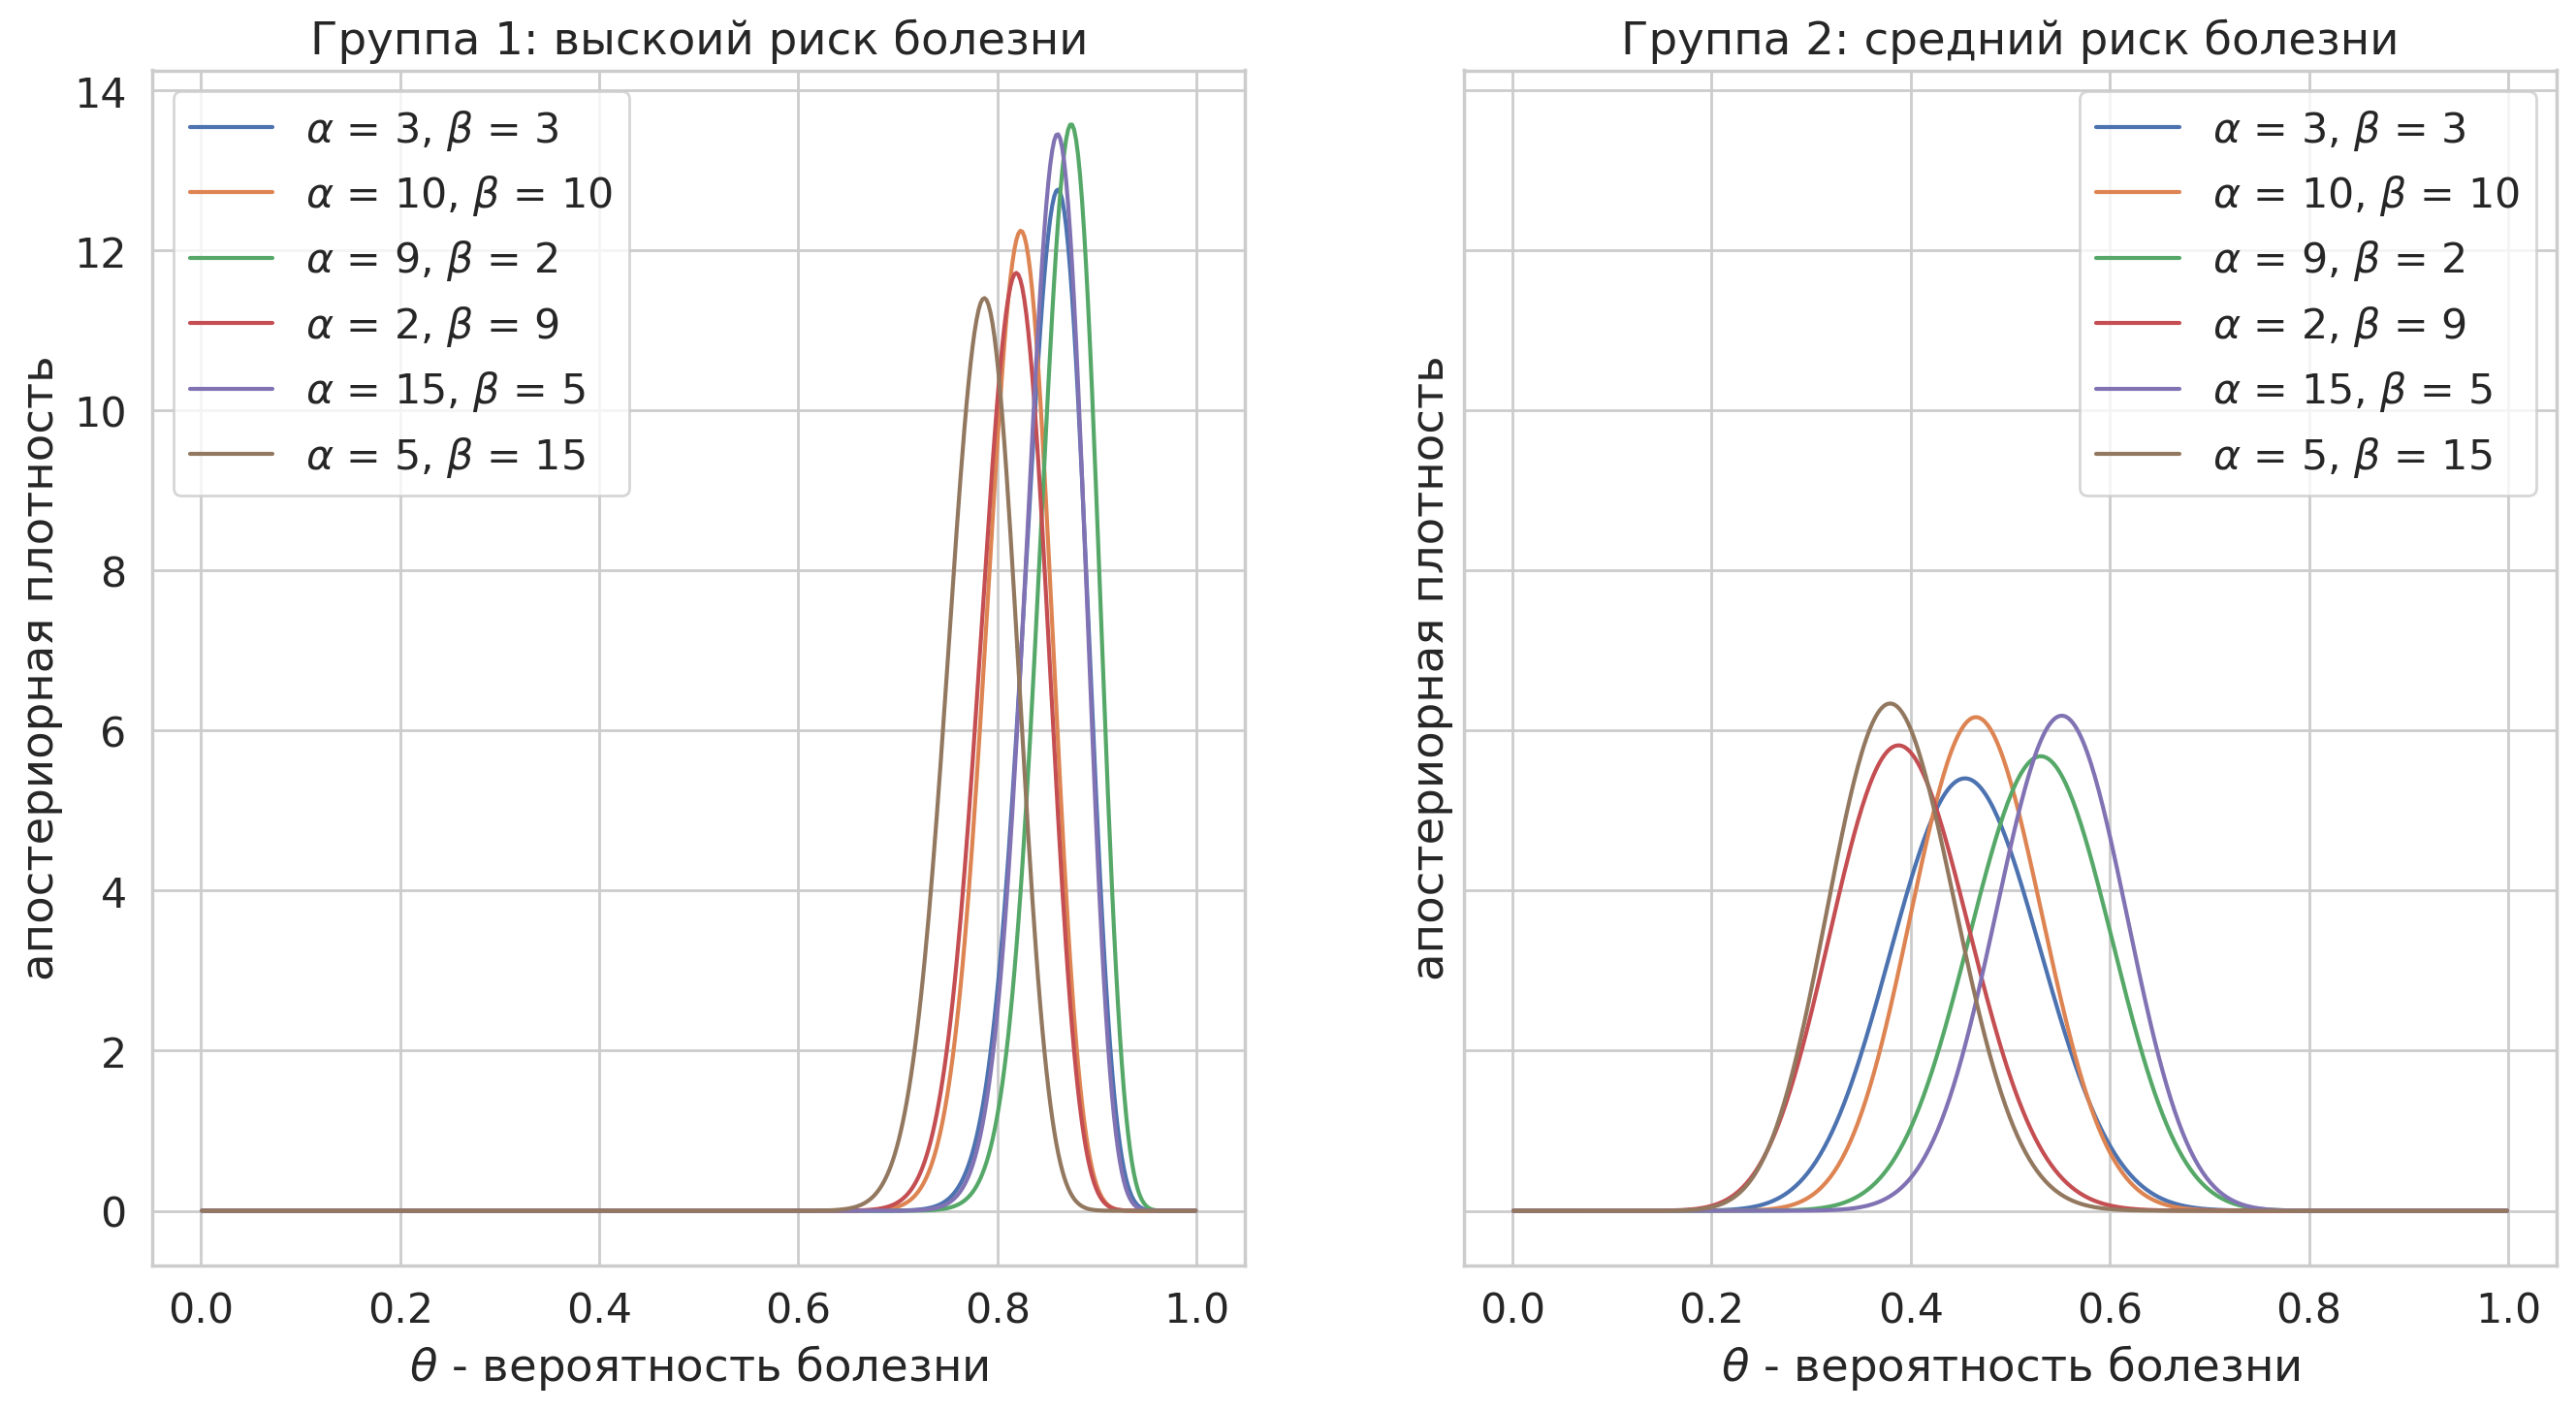

In [314]:
group1 = df[(df["age_bin"]  == "age>=55") & (df["chol_bin"] == "chol>=250") &
        (df["sex_bin"]  == "male") & (df["fbs_bin"]  == "fbs<=120")]

group2 = df[(df["age_bin"]  == "age>=55") & (df["chol_bin"] == "chol<250") &
        (df["sex_bin"]  == "male") & (df["fbs_bin"]  == "fbs>120")]


priors = [("Распр. равномерно, импакт слабый", 3, 3),
        ("Распр. равномерно, импакт сильный", 10, 10),
        ("Больше больных, испакт слабый", 9, 2),
        ("Больше здоровых, испакт слабый", 2, 9),
        ("Больше больных, испакт сильный", 15, 5),
        ("Больше здоровых, испакт сильный", 5, 15)]


fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
theta = np.linspace(0.001, 0.999, 500)
for name, alpha, beta in priors:
    axes[0].plot(theta, sps.beta(alpha + group1["target"].sum(), beta + len(group1) - group1["target"].sum()).pdf(theta),
                 label=r"$\alpha$ = " + str(alpha) + r", $\beta$ = " + str(beta))

    axes[1].plot(theta, sps.beta(alpha + group2["target"].sum(), beta + len(group2) - group2["target"].sum()).pdf(theta),
                 label=r"$\alpha$ = " + str(alpha) + r", $\beta$ = " + str(beta))


axes[0].set_title("Группа 1: выскоий риск болезни"); axes[1].set_title("Группа 2: средний риск болезни")
for ax in axes: ax.set_xlabel(r"$\theta$ - вероятность болезни"); ax.set_ylabel("апостериорная плотность"); ax.legend(loc="best")

plt.show()

Хорошо ли точечная оценка максимума плотности отражает поведение параметра? Стал ли богатый байес лучше бедного?

<font color="#ae69c9ff">

1. Думаю, да, особенно хорошо в случае "уверенного" риска/его отсутсвия. Но она не робастна
2. Стал ли? - да не сильно. Но хорошо, что появилась возможность за бесплатно строить ДИ от исходных предположений. Хотя для умеренного риска богатый байес даёт ощутимо больше информации

👍

 ### Часть 2

В прошлом пункте Вы смотрели на р**а**зницу в оценках и исходя из этого делали выводы влияют ли на неё фичи, по которым мы разбивали пациентов. Это нестрогий подход. Воспользуемся принципом наибольшей обоснованности.

1. Сформулируйте принцип наибольшей обоснованности и напишите точную формулу по которой будете считать обоснованность в нашей за**да**че (знаменатель формулы Байеса). *Указание: формула была на лекции*.

**Ответ:**

<font color="#ae69c9ff">

Будем поедполагать, что в данной задаче различные модели - есть различные столбцы, тогда: $$p(X | M_i, \alpha, \beta) = \int_0^1 p(X | \theta_i, M_i) p(\theta_i | M_i, \alpha, \beta) d\theta_i$$
Пользуясь прелыдущими выкладками, получим, что: $$p(X | M_i, \alpha, \beta) = \prod_{j \in M_i} \frac{B(\alpha + n_j, \beta + m_j)}{B(\alpha, \beta)}$$
Заметим, что это всё есть чиселки -> они сравнимы, ну и сама $p(X | M_i, \alpha, \beta)$ - есть вероятность получить "такой" результат при "таких" гиперпараметрах

Кроме того, имеет смысл говорить про степень полученной чиселки (бета функцию выносить не буду, ибо хочу жить в нотации книжки, мне так проще)

При подсчёте обоснованности можете зарание сократить общие множители всех обоснованностей и не считать их, на сравнение они не повлияют.

2. Рассчитайте обоснованность для каждого признака:

In [315]:
def log_evidence(col, alpha, beta):
    group = df.groupby(col)["target"]
    return (spsp.betaln(alpha + group.sum(), beta + group.size() - group.sum()) - spsp.betaln(alpha, beta)).sum()

cols = ["age_bin", "chol_bin", "sex_bin", "fbs_bin"]
for name, alpha, beta in priors:
    print(name, r" $\alpha$ = " + str(alpha) + r", $\beta$ = " + str(beta))
    log_evs = {c: log_evidence(c, alpha, beta) for c in cols}
    max_log_ev = max(log_evs.values())
    [print("    ", c, f"{log_evs[c]: .3f}", r"\delta = ", f"{log_evs[c] - max_log_ev: .3f}") for c in cols]
    print()


Распр. равномерно, импакт слабый  $\alpha$ = 3, $\beta$ = 3
     age_bin -678.102 \delta =  -4.103
     chol_bin -703.352 \delta =  -29.353
     sex_bin -673.999 \delta =   0.000
     fbs_bin -713.482 \delta =  -39.482

Распр. равномерно, импакт сильный  $\alpha$ = 10, $\beta$ = 10
     age_bin -677.866 \delta =  -3.478
     chol_bin -702.426 \delta =  -28.038
     sex_bin -674.388 \delta =   0.000
     fbs_bin -712.314 \delta =  -37.926

Больше больных, испакт слабый  $\alpha$ = 9, $\beta$ = 2
     age_bin -683.546 \delta =  -2.176
     chol_bin -708.120 \delta =  -26.750
     sex_bin -681.370 \delta =   0.000
     fbs_bin -717.900 \delta =  -36.531

Больше здоровых, испакт слабый  $\alpha$ = 2, $\beta$ = 9
     age_bin -682.671 \delta =  -5.617
     chol_bin -708.099 \delta =  -31.046
     sex_bin -677.054 \delta =   0.000
     fbs_bin -718.244 \delta =  -41.190

Больше больных, испакт сильный  $\alpha$ = 15, $\beta$ = 5
     age_bin -683.807 \delta =  -1.183
     chol_bin -707.783 \

/tmp/ipykernel_278734/3578741571.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group = df.groupby(col)["target"]
/tmp/ipykernel_278734/3578741571.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group = df.groupby(col)["target"]
/tmp/ipykernel_278734/3578741571.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group = df.groupby(col)["target"]
/tmp/ipykernel_278734/3578741571.py:2: FutureWarning: The default o

Все ли признаки полезны? Если оказалось, что да, то добавьте новый самый бесполезный признак и покажите, что обоснованность падает.

Какие модели самые обоснованные? Почему?

**Вывод:**

<font color="#ae69c9ff">

1. Моделька не выдаёт абсолютного значения, есть только стравнительный результат. Относительно самого полезного - пола, да, `fbs` даёт сильно меньше импакта (ну раз так в $10^{17}$). Особенно хорошо это видно при сравнении с предыдущими результами.
2. Наиболее обоснованными моделями выглядят пол и возраст, что в принципе логично, наверное... Ну, возраст - понятно, пол - ну просто так получилось. Я не кардилог... _Предлагаю во всём обвинить женщин (извините)_

<font color='red'>
Осуждаю!
</color>

<font color='green'><b>
Итог: 9 баллов
</color>

## Задача 2. Метод релевантных векторов

*Данная задача стоит 15 баллов (10 за метод релевантных векторов и 5 за байесовский инференс).*

В этой задаче нам придётся сравнивать результат с задачей 3 из домашки 4 про регрессию. Если Вы её не решали, то в этой задаче для 10 любых признаков соберите модель с R2 коэффициентом хотя бы 0.7.

В данной задаче Вы научитесь:
- Делать отбор признаков на основании метода наибольшей обоснованности

In [316]:
!gdown https://drive.google.com/uc?id=1wphoJPm4LA3-Mo_l7TRsq9uRdXkzCJqe

import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

Downloading...
From: https://drive.google.com/uc?id=1wphoJPm4LA3-Mo_l7TRsq9uRdXkzCJqe
To: /home/ivan/Desktop/stats/stats_private/HW_5_raw/train.csv
100%|████████████████████████████████████████| 461k/461k [00:00<00:00, 1.04MB/s]


In [317]:
df = pd.read_csv("train.csv")
df = df.rename(columns={"1stFlrSF": "FirstFlrSF"})

qual_map = {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
bsmt_exposure_map = {"NA": 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4}
bsmt_fin_type_map = {"NA": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}

for col in ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "HeatingQC", "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond", "PoolQC"]: df[col] = df[col].map(qual_map)
for col in ["BsmtExposure"]: df[col] = df[col].map(bsmt_exposure_map)
for col in ["BsmtFinType1", "BsmtFinType2"]: df[col] = df[col].map(bsmt_fin_type_map)


bin_maps = {"Street": {"Grvl": 0, "Pave": 1}, "Alley": {"Grvl": 0, "Pave": 1},
    "CentralAir": {"N": 0, "Y": 1}, "Utilities": {"ELO": 0, "NoSeWa": 1, "NoSewr": 2, "AllPub": 3}}
for col, m in bin_maps.items(): df[col] = df[col].map(m)


mask = df.select_dtypes(include=[np.number]).columns
filtered_df = df[df[mask].corr()["SalePrice"].abs().sort_values(ascending=False).head(15).index.tolist()]


filtered_df.drop(columns=["TotRmsAbvGrd", "GarageArea", "FirstFlrSF"], inplace=True) # С таким набором признаков получим R^2 = 0.787
filtered_df.drop(columns=["YearRemodAdd"], inplace=True)
filtered_df.drop(columns=["Alley"], inplace=True)


futures = filtered_df.columns.tolist()[1:]
formula = "SalePrice ~ " + " + ".join(futures)
simple_model = smf.ols(formula, data=filtered_df)
print(simple_model.fit(cov_type="HC1").summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     278.3
Date:                Sat, 13 Dec 2025   Prob (F-statistic):          2.25e-305
Time:                        23:43:12   Log-Likelihood:                -16974.
No. Observations:                1423   AIC:                         3.397e+04
Df Residuals:                    1413   BIC:                         3.402e+04
Df Model:                           9                                         
Covariance Type:                  HC1                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -2.972e+05   1.23e+05     -2.426      

/tmp/ipykernel_278734/3777949924.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.drop(columns=["TotRmsAbvGrd", "GarageArea", "FirstFlrSF"], inplace=True) # С таким набором признаков получим R^2 = 0.787
/tmp/ipykernel_278734/3777949924.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.drop(columns=["YearRemodAdd"], inplace=True)
/tmp/ipykernel_278734/3777949924.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

In [318]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

mask = df.select_dtypes(include=[np.number]).columns
filtered_df = df[df[mask].corr()["SalePrice"].abs().sort_values(ascending=False).head(28).index.tolist()]

na_counts = filtered_df.isna().sum().sort_values(ascending=False)
print(na_counts)

PoolQC          1453
Alley           1369
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
BsmtExposure      38
BsmtQual          37
MasVnrArea         8
ExterQual          0
GrLivArea          0
SalePrice          0
OverallQual        0
FullBath           0
FirstFlrSF         0
TotalBsmtSF        0
GarageArea         0
KitchenQual        0
GarageCars         0
YearRemodAdd       0
TotRmsAbvGrd       0
HeatingQC          0
Fireplaces         0
YearBuilt          0
BsmtFinSF1         0
WoodDeckSF         0
2ndFlrSF           0
OpenPorchSF        0
HalfBath           0
dtype: int64


<font color="#ae69c9ff">

Первым трём не повезло, их выкинем, все остальные оставим. Есть предположение, что лучше выкинуть только первые 2, но не уверен. Потестирую. 

Потестировал, разницы 0. Удалим фичу и оставим датасет чуть большего размера

In [319]:
filtered_df.drop(columns=["Alley", "PoolQC", "LotFrontage", "FireplaceQu"], inplace=True)
futures = filtered_df.columns.tolist()[1:]


filtered_df.dropna(inplace=True)

X = filtered_df[futures].values
T = filtered_df["SalePrice"].values

lasso = LassoCV(cv=5, random_state=0).fit(StandardScaler().fit_transform(X), T)
coef = pd.Series(lasso.coef_, index=futures)
selected = coef[coef != 0].index.tolist()


print("Фичи, не бесполезные по мнению LASSO:", selected)

formula = "SalePrice ~ " + " + ".join(selected)
model_lasso = smf.ols(formula, data=filtered_df)
print(simple_model.fit(cov_type="HC1").summary())


Фичи, не бесполезные по мнению LASSO: ['OverallQual', 'GrLivArea', 'ExterQual', 'KitchenQual', 'BsmtQual', 'GarageCars', 'GarageArea', 'TotalBsmtSF', 'FirstFlrSF', 'TotRmsAbvGrd', 'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea', 'Fireplaces', 'HeatingQC', 'BsmtFinSF1', 'BsmtExposure', 'WoodDeckSF']
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     278.3
Date:                Sat, 13 Dec 2025   Prob (F-statistic):          2.25e-305
Time:                        23:43:12   Log-Likelihood:                -16974.
No. Observations:                1423   AIC:                         3.397e+04
Df Residuals:                    1413   BIC:                         3.402e+04
Df Model:                           9                                   

/tmp/ipykernel_278734/1363244419.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.drop(columns=["Alley", "PoolQC", "LotFrontage", "FireplaceQu"], inplace=True)
/tmp/ipykernel_278734/1363244419.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.dropna(inplace=True)


<font color="#ae69c9ff">

Добавил отбор признаков через L1 регуляризацию, но ничего не поменялось. `Adj. R-squared` буквально не изменился.
Получается, я хорошо сделал предыдущую домашку _или допустил одинковые ошибки_

![image.png](try_1.png)

1. Отбор фичей. Условие тут очень простое: для датасета из задачи 3 домашки 4 выберите 20 любых признаков (можно взять топ20 самых лучших, отобранных ранее).

При помощи **м**етода наибольшей обоснованности напишите вычисление оптимальных априорных параметров (регуляризаторов для каждой фичи).

Нарисуйте следующие графики сходимости:
- график обоснованности
- график количества фичей, для которых регуляризатор стал больше некоторого порога (выберите его сами), после которого мы считаем что фичу надо выбросить совсем
- График R2 для модели с текущими регуляриз**а**торами.

<font color="#ae69c9ff">

Сложно. Это очень сложно. Так вот:

Я хочу жить в нотации книжки.\
Мат. модель: $$p(T | X, \omega, \beta) = N(T | X \omega, \beta^{-1} I_n)$$
$$\text{Априорное распр.:} \ p(\omega | A) = N(0, A^{-1}), \ A = diag(\alpha_1, \ \dots, \ \alpha_m)$$
$$\text{Постериорное распр.:} \ p(\omega | X, T, A, \beta) = N(\omega_{MP}, \Sigma), \ \ \text{где} \ \omega_{MP} = \beta \Sigma X^{\top} T; \ \Sigma = (\beta X^{\top} X + A)^{-1}$$

<font color="#ae69c9ff">

$$\alpha_i^{new} = \frac{1-\alpha_i^{old} \Sigma_{ii}}{\omega_{MP, i}^2}; \ A^{new} = (I - A^{old} \Sigma)(diag(\omega_{MP}^{2}))^{-1}$$
$$\beta^{new} = \frac{n - \sum_{i=1}^{m}1-\alpha_i^{old} \Sigma_{ii}}{\lVert T - X \omega_{MP} \rVert^2}$$
$$log \ p(T | X, A, \beta) = \frac{n}{2} log(\beta) - \frac{n}{2} log(2\pi) + \frac{1}{2} log(det(A)) - \frac{\beta}{2} {\lVert T - X \omega_{MP} \rVert^2} - \frac{1}{2} \omega_{MP}^{\top} A \omega_{MP} - \frac{1}{2}log(det(\Sigma^{-1}))$$
$$R^2 = 1 - \frac{D(Y | X)}{D(X)} = 1 - \frac{\lVert T - X \omega_{MP} \rVert^2}{\lVert T - \overline T \rVert^2}$$

<font color="#ae69c9ff">

Ремарка: на каждой итерации метода мы пересчитываем $\Sigma$ и $\omega_{MP}$. Я попробовал написать ещё и верхние индексы, но это вообще нечитаемо становится

/tmp/ipykernel_278734/130891832.py:18: RuntimeWarning: invalid value encountered in log
  lp = (n/2*np.log(beta) - n/2*np.log(2*np.pi) + 1/2*np.log(np.linalg.det(A)) - beta/2*np.linalg.norm(T-X@omega)**2
/tmp/ipykernel_278734/130891832.py:19: RuntimeWarning: invalid value encountered in log
  - 1/2*omega.T@A@omega - 1/2*np.log(np.linalg.det(beta * X.T @ X + A_old)))


[4.90334041e-009 7.68397706e-004 7.38331679e-009 5.79024248e-009
 7.51401222e-009 8.55061686e-009 3.83875288e-003 2.46597744e-002
 1.34066627e-002 2.28970747e-003 1.46846280e-007 1.36614750e+013
 4.36096134e-003 1.12569419e-004 1.46511311e-003 1.96279087e-008
 1.78208742e-007 4.46337843e-003 2.85720810e-008 2.03036791e-003
 3.62177578e+012 6.06470467e+219 1.44519121e-002]


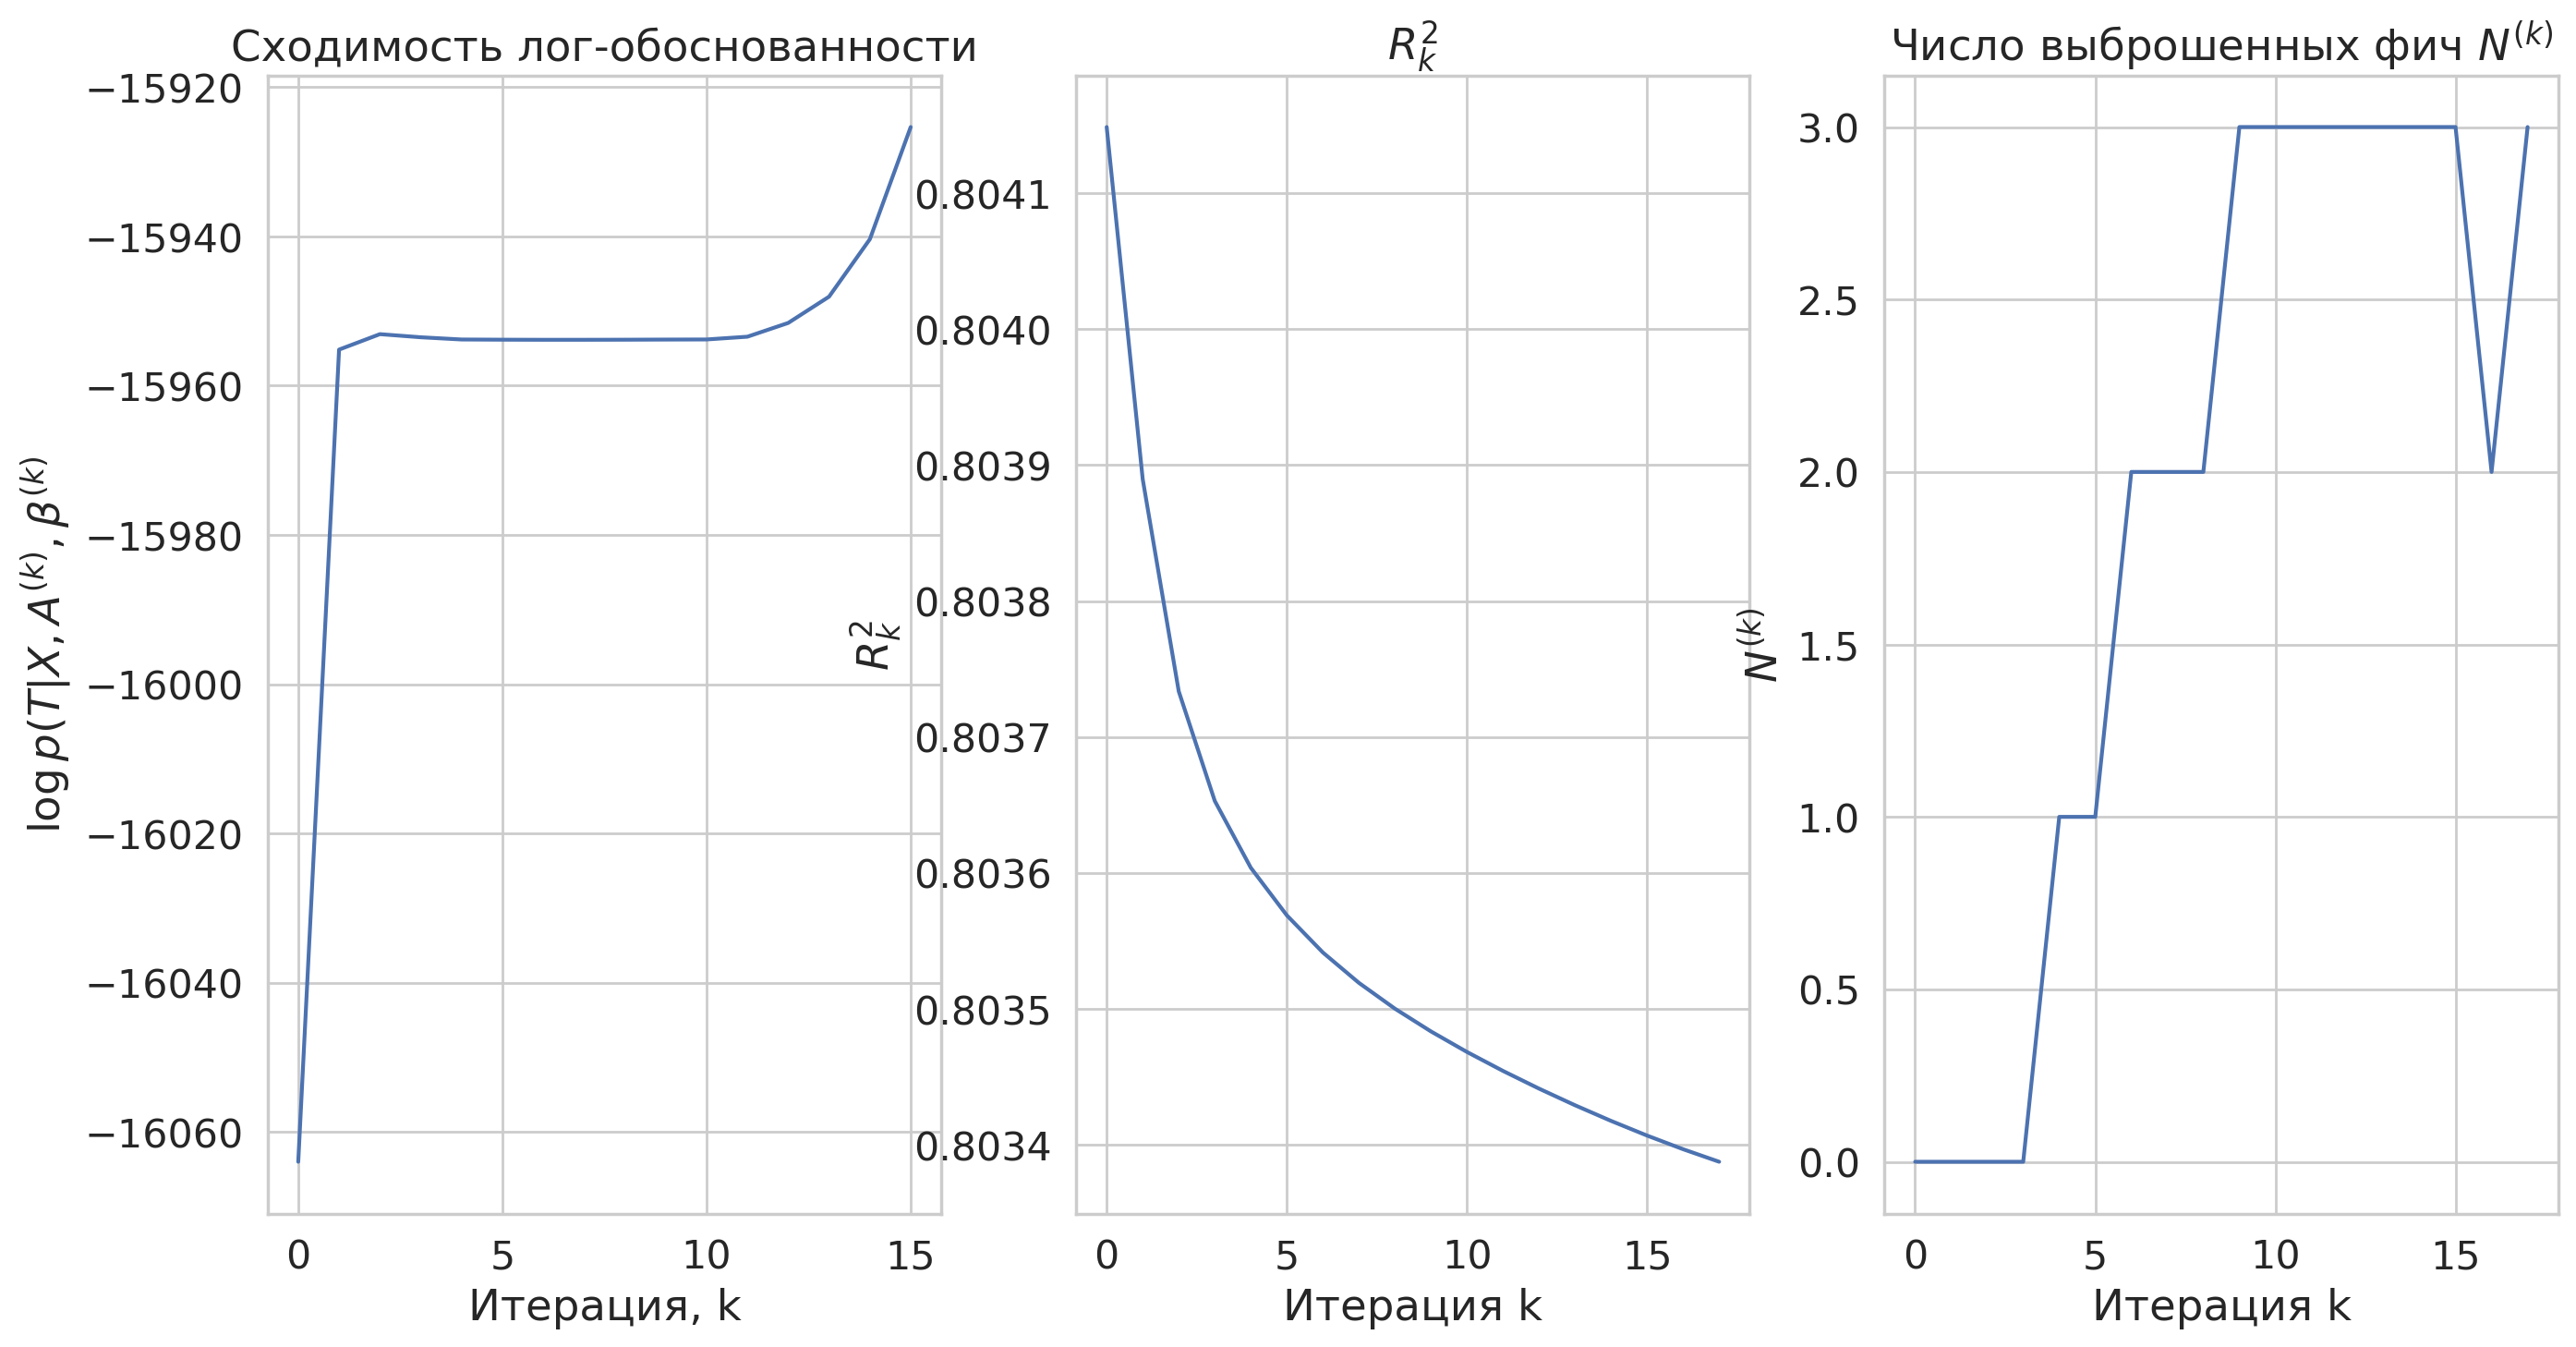

In [320]:
m = len(futures)
n = X.shape[0]
A = np.diag(np.ones(m))
beta = 1

N = 18 # было интересно посмотреть потолок. Дальше падает.
n_range = np.arange(0, N)

ans = np.zeros((N, 3))
for i in n_range:
    Sigma = np.linalg.inv(beta * X.T @ X + A)
    omega = beta * Sigma @ X.T @ T
    A_old = A

    A = (np.diag(np.ones(m)) - A_old @ np.diag(np.diag(Sigma))) @ np.linalg.inv((np.diag(omega ** 2)))
    beta = (n - np.trace(np.diag(np.ones(m)) - A_old @ np.diag(np.diag(Sigma)))) / np.linalg.norm(T - X @ omega) ** 2

    lp = (n/2*np.log(beta) - n/2*np.log(2*np.pi) + 1/2*np.log(np.linalg.det(A)) - beta/2*np.linalg.norm(T-X@omega)**2 
          - 1/2*omega.T@A@omega - 1/2*np.log(np.linalg.det(beta * X.T @ X + A_old)))
    R2 = 1 - np.linalg.norm(T - X @ omega) ** 2 / np.linalg.norm(T - T.mean()) ** 2
    Num = np.sum(np.diag(A) > 10 ** 4)

    ans[i] = (lp, R2, Num)


fig, axes = plt.subplots(1, 3, figsize=(16, 8))

axes[0].plot(n_range, ans[:, 0], label=r"_")
axes[0].set_title("Сходимость лог-обоснованности"); axes[0].set_xlabel("Итерация, k"); axes[0].set_ylabel(r"$\log p(T | X, A^{(k)}, \beta^{(k)}$")
axes[1].plot(n_range, ans[:, 1], label=r"_")
axes[1].set_title(r"$R^2_k$"); axes[1].set_xlabel("Итерация k"); axes[1].set_ylabel(r"$R^2_k$")
axes[2].plot(n_range, ans[:, 2], label=r"_")
axes[2].set_title(r"Число выброшенных фич $N^{(k)}$"); axes[2].set_xlabel("Итерация k"); axes[2].set_ylabel(r"$N^{(k)}$")


print(np.diag(A))

<font color="#ae69c9ff">

Есс, 3 бесполезные фичи (https://youtu.be/khZA0pd1gEE?si=DtYm5_gXMfh4RMKJ).

Алгос классный, сходится невероятно быстро, всего за 10 итераций. Далее виден второй пик лог правдоподобия, но это уже обусловлено проблемами с точностью. Некоторые веса взрываются, что говорит об их бесполезности.

👍

Изучите получен**н**ые регуляризаторы. Какие фичи надо выкинуть совсем, а какие можно оставить с предлагаемым весом?

In [321]:
trash = [futures[i] for i in np.where(np.diag(A) > 10 ** 4)[0]]
print(trash)

['YearBuilt', '2ndFlrSF', 'OpenPorchSF']


<font color="#ae69c9ff">

Чем выше $A_i$, тем ниже дисперсия соотв. признака в нотации байесовской модели. А это уже непосредственно указывает на его бесполезность по причине неотличимости от нуля -> выкидываем

Есть проблема: признаков так-то много и очевидно, что многие из них л.з.. Проверим, не выстрелит ли это нам в колено

Давайте сравним, стала ли модель лучше. На конкурс выходят 3 (или 2, если Вы не решали задачу 4 домашки 4) модели:
- Модель с 10 случайными фичами из 20 имеющихс**я**
- Модель, полученная в результате метода релевантных векторов
- Лучшая модель из задачи 4 домашки 4.

Сравните эти модели при помощи R2 (с поправкой) и информационных коэффициентов. Сделайте выводы.

In [322]:
filtered_df.drop(columns=trash, inplace=True)
futures = filtered_df.columns.tolist()[1:]
formula = "SalePrice ~ " + " + ".join(futures)
model = smf.ols(formula, data=filtered_df)
print(model.fit(cov_type="HC1").summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     180.5
Date:                Sat, 13 Dec 2025   Prob (F-statistic):               0.00
Time:                        23:43:13   Log-Likelihood:                -15918.
No. Observations:                1340   AIC:                         3.188e+04
Df Residuals:                    1319   BIC:                         3.199e+04
Df Model:                          20                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -1.056e+05   2.37e+05     -0.446   

/tmp/ipykernel_278734/2725787793.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.drop(columns=trash, inplace=True)


<font color="#ae69c9ff">

Ахах, ну, вообще так-то прикольно. Почти за бесплатно по вычислениям + времени мы получили улучшение модели на $0.016$ в нотации $R^2-adj$, не прикладывая умственных усилий для вычленения бесполезных фичей. _Вкалывают роботы... Счаслив человек!_

2. Байесовский инференс.

Выберите любую строку в данных. Давайте будем считать, что она тестовая (формально это неправильно, так как она в трейне была, так что при желании можете переобучить модель без неё, но это не сильно важно). Выпишите формулу вычисления распределения таргета (цены дома) в зависимости от фичей $P(Y|X)$. Какое распределение с какими параметрами получится?

Указание: Распишите плотность одного элемента $P(y_{test}|X_{test})$ как интеграл (на лекции расписывали). Внутри интеграла сделай**т**е то же преобразование, при помощи которого на лекции считалась обоснованность (разложение в ряд Тейлора в окрестности максимума). Для вычисления максимума Вам потребуется формула Шермана-Моррисона https://en.wikipedia.org/wiki/Sherman%E2%80%93Morrison_formula.

**Ответ:**

<font color="#ae69c9ff">

My skill issue. Это сложно, я потратил 4+ часа, чтобы вникуть, но у меня не получилось сдвинуться с нулевой точки.

😢

Нарисуйте плотность предсказанной цены на дом с учётом его фичей. Вертикальной линией нарисуйте настоящую цену на дом.

Найдите ДИ уровня доверия 95% цены на дом по плотности выше. Попадает ли настоящая цена в этот ДИ?

В качестве вывода напишите, чем лучше делать байесовский инференс модели регрессии по сравнению с классической регрессией (она же будет байесом для бедных):

**Вывод:**

<font color='green'><b>
Итог: 10 баллов
</color>

## Задача 3. Сэмплирование

*Данная задача стоит 10 баллов*

В данной задаче Вы научитесь:
- Генерировать выборки из распреде**л**ений с сложной плотностью
- Приближённо считать интегралы с сложной плотностью (особенно возникающие в байесовском анализе)

Итак, решается задача вычисления $\int\limits_a^b f(x) g(x) dx$, где $f(x)$ это какая-то функция, а $g(x)$ это плотность распределения. Такие интегралы, как Вы видели в задаче 2 появля**ю**тся при вычислении ответа байесовской модели на тестовых данных. Если интеграл не берётся аналитически, то приходится выкручиваться.

В рамках данной задачи предлагается брать интеграл функции $\log{|x|}$ по плотности нормального распределения $\mathcal{N}(0, 1)$. Для референса найдите этот интеграл при помощи `scipy.quad` как можно точнее. Это будет "правильный ответ" для сравнения. Если Вы Святогор-Богатырь, можете найти его аналитически.

In [323]:
ref, _ = spi.quad(lambda x: np.log(np.abs(x)) * sps.norm.pdf(x), -np.inf, np.inf, limit=500)
print("Реф. значение: ", ref)

Реф. значение:  -0.6351814227307317


1. Rejection sampling

Используя для пробирования равномерное распределение на большом отрезке (скажем [-1000, 1000]) научитесь сэмплировать нормальные данные (да, формально мы сэмплируем не N(0, 1), а его обрезанную версию, но этого должно хватить). Проверьте, что получается нужное распределение любым критерием согласия.

<font color="#ae69c9ff">

Пусть $X \in [-M; M]$, где в нашем случае $M = 1000$, максимум в нуле $\rightarrow \ c = \frac{2M}{\sqrt{2\pi}}$, ну и тогда:
$$g(x) = \frac{1}{2m}, \ f(x) = \frac{1}{\sqrt{2\pi}}e^{\frac{-x^2}{2}}; \ \frac{f(x)}{cg(x)} = \dots = e^{\frac{-x^2}{2}}$$

In [324]:
ALPHA = 0.05

def giga_func(X, X_pdf, N, name):
    Y = sps.uniform(0, 1).rvs(N, random_state=4)

    x = np.linspace(-10, 10, 10000)
    c = np.max(sps.norm(0, 1).pdf(x) / X_pdf(x))

    X = X[Y < sps.norm(0, 1).pdf(X) / (X_pdf(X) * c)]

    print("Результаты для", name + ":")
    
    pvalue = sps.shapiro(X).pvalue
    print("По мнению критерия Шапиро-Уилка нормальность распределения полученной выборки", "отвергается" if pvalue < ALPHA else "не отвергается")

    print("Из", N, "элементов на входе получили", X.shape[0], "на выходе")

    I = np.mean(np.log(np.abs(X[:1000])))
    print(r"\int =", I)
    print("Ошибка:", np.abs(I - ref))
    print()

N = 1000000
giga_func(sps.uniform(-1000, 2000).rvs(N), sps.uniform(-1000, 2000).pdf, N, "равномерного распределения")

Результаты для равномерного распределения:
По мнению критерия Шапиро-Уилка нормальность распределения полученной выборки не отвергается
Из 1000000 элементов на входе получили 1289 на выходе
\int = -0.6282393218775638
Ошибка: 0.006942100853167932



<font color="#ae69c9ff">

А, так это настолько ~~плохо~~ неэффективно работает. Сильно.
Из теории, которую можно почитать, а Виталий сказал, что это всё счастье пока бд (хотя относительно второй задачи там не сложно), получаем, что вероятность принять $\sim \frac{1}{c}$ (для нашего случая), ну вот то на то и вышло. Нам надо 800к элементов.

Если критерий не отвергается, то посчитайте интеграл на выборке из 1000 элементов и сравните с ответом. Сколько Вы провели всего сэмплирований из равномерного распределения, перед тем как получили вы**бо**рку из 100 элементов?

<font color="#ae69c9ff">

Не знаю, не с чем сравнить пока, но вообще прикольно. Почти за бесплатно посчитали интеграл с вроде как неплохой точностью

Предложите 2-3 другие пробные функции, которые Вы сможете сэмплировать без scipy.stats.rvs. Попробуйте получить 100 элементов нормальной выборки. Как много попыток нужно?

In [325]:
N = 5000
giga_func(1 / np.tan(np.pi * (sps.uniform(0, 1).rvs(N) - 1 / 2)), lambda x: 1 / (np.pi * (x ** 2 + 1)), N, "распр. Коши")

uni = sps.uniform(0, 1).rvs(N, random_state=43)
giga_func(np.where(uni < 0.5, np.log(2 * uni), -np.log(2 * (1 - uni))), lambda x: 0.5 * np.exp(-np.abs(x)), N, "распр. Лапласа")

Результаты для распр. Коши:
По мнению критерия Шапиро-Уилка нормальность распределения полученной выборки не отвергается
Из 5000 элементов на входе получили 3300 на выходе
\int = -0.6359402780651177
Ошибка: 0.0007588553343859106

Результаты для распр. Лапласа:
По мнению критерия Шапиро-Уилка нормальность распределения полученной выборки не отвергается
Из 5000 элементов на входе получили 3772 на выходе
\int = -0.6730056955851295
Ошибка: 0.03782427285439771



Сделайте вывод о том, как лучше подбирать пробное распределение.

<font color="#ae69c9ff">

1. Стоит приближать чем-то похожим на исходное, иначе считаться будет n миллионов лет
2. Хвосты у того, чем приближаем должны быть тяжелее, чем у того, что приближаем

Кроме того, нет особой разницы в точности подсчёта интеграла при различных методах получения выборки -> точность скорее всего обусловлена количеством элементов 

👍

2. Importance sampling

Отказываться от уже просэмплированных данных плохо, можно им регулировать вес в сумме. Для предложенных ранее пробных распределений получите оценку интеграла методом importance sampling. Делайте выборки такого размера, сколько было нужно по**пыт**ок в прошлом пункте (для честности сравнения).

In [326]:
def giga_func_2(X, X_pdf, N, name):
    Y = sps.uniform(0, 1).rvs(N, random_state=4)
    I = np.mean(np.log(np.abs(X[:1000])) * sps.norm(0, 1).pdf(X[:1000]) / X_pdf(X[:1000]))
    
    print("Результаты для", name + ":")
    print(r"\int =", I)
    print("Ошибка:", np.abs(I - ref))
    print()

N = 1000000
giga_func_2(sps.uniform(-1000, 2000).rvs(N), sps.uniform(-1000, 2000).pdf, N, "равномерного распределения")

N = 5000
giga_func_2(1 / np.tan(np.pi * (sps.uniform(0, 1).rvs(N) - 1 / 2)), lambda x: 1 / (np.pi * (x ** 2 + 1)), N, "распр. Коши")

uni = sps.uniform(0, 1).rvs(N, random_state=43)
giga_func_2(np.where(uni < 0.5, np.log(2 * uni), -np.log(2 * (1 - uni))), lambda x: 0.5 * np.exp(-np.abs(x)), N, "распр. Лапласа")

Результаты для равномерного распределения:
\int = -2.6698310649012558
Ошибка: 2.034649642170524

Результаты для распр. Коши:
\int = -0.6096376856250522
Ошибка: 0.025543737105679587

Результаты для распр. Лапласа:
\int = -0.6389621101809431
Ошибка: 0.0037806874502113175



<font color="#ae69c9ff">


Ответы классные, метод предварительно на порядок сильнее предыдущего с точки зрения "посмотреть на ответ", но сравнимостью здесь и не пахнет. Сделаем её отдельно на выборках по 50000 элементов (для балланса вселенной)

In [327]:
N = 50000
giga_func(sps.uniform(-1000, 2000).rvs(N), sps.uniform(-1000, 2000).pdf, N, "равномерного распределения")
giga_func(1 / np.tan(np.pi * (sps.uniform(0, 1).rvs(N) - 1 / 2)), lambda x: 1 / (np.pi * (x ** 2 + 1)), N, "распр. Коши")
uni = sps.uniform(0, 1).rvs(N, random_state=43)
giga_func(np.where(uni < 0.5, np.log(2 * uni), -np.log(2 * (1 - uni))), lambda x: 0.5 * np.exp(-np.abs(x)), N, "распр. Лапласа")


giga_func_2(sps.uniform(-1000, 2000).rvs(N), sps.uniform(-1000, 2000).pdf, N, "равномерного распределения")
giga_func_2(1 / np.tan(np.pi * (sps.uniform(0, 1).rvs(N) - 1 / 2)), lambda x: 1 / (np.pi * (x ** 2 + 1)), N, "распр. Коши")
uni = sps.uniform(0, 1).rvs(N, random_state=43)
giga_func_2(np.where(uni < 0.5, np.log(2 * uni), -np.log(2 * (1 - uni))), lambda x: 0.5 * np.exp(-np.abs(x)), N, "распр. Лапласа")

Результаты для равномерного распределения:
По мнению критерия Шапиро-Уилка нормальность распределения полученной выборки не отвергается
Из 50000 элементов на входе получили 56 на выходе
\int = -0.6410897843954493
Ошибка: 0.005908361664717532

Результаты для распр. Коши:
По мнению критерия Шапиро-Уилка нормальность распределения полученной выборки не отвергается
Из 50000 элементов на входе получили 32939 на выходе
\int = -0.650370139984855
Ошибка: 0.015188717254123296

Результаты для распр. Лапласа:
По мнению критерия Шапиро-Уилка нормальность распределения полученной выборки не отвергается
Из 50000 элементов на входе получили 37927 на выходе
\int = -0.6730056955851295
Ошибка: 0.03782427285439771

Результаты для равномерного распределения:
\int = 0.01982269038318551
Ошибка: 0.6550041131139173

Результаты для распр. Коши:
\int = -0.6035867036599407
Ошибка: 0.03159471907079103

Результаты для распр. Лапласа:
\int = -0.6389621101809431
Ошибка: 0.0037806874502113175



/home/ivan/.local/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 32939.
  res = hypotest_fun_out(*samples, **kwds)
/home/ivan/.local/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 37927.
  res = hypotest_fun_out(*samples, **kwds)


Сделайте вывод о том, работает ли новый метод лучше старого.

<font color="#ae69c9ff">

Беглым взглядом кажется, что резултаты очев и всё хорошо, но сказать так будет ошибкой с моей стороны. Полноценных выводов сделать нельзя. иб мы не исследовали ворпос дисперсии полученных результатов и примерно ничего не знаем про теор. выкладки, обосновывающие это.\
Предварительно второй метод даёт результат хуже относительно первого для сильно отличающихся распределений. В общем, это что-то интересное, жду пруфов 👍

👍

3. Метод Метрополиса-Гастингса

Предложите любую функцию перехода, кроме нормальной (не обязательно уметь её самому сэмплировать, но она должна от нормального распределения отличаться). Напишите формулу получения новой величины методом Метрополиса-Гастингса.

**Ответ:**

<font color="#ae69c9ff">

$x' = x - \varepsilon; \ x + \varepsilon$, где каждый из исходов определяется броском честной монетки, а $\varepsilon \sim U(0, \ h)$.
$$\phi(x \rightarrow x') = min \left( 1, \ \frac{\pi(x')p(x|x')}{\pi(x)p(x'|x)} \right), \ \ \text{где } \pi \text{ - целевая плотность}$$
Дальше короче вообще мувы, мувы. Посмотрим на переходы и заметим, что они симметричны + всё это сходится по известной теореме [ДАННЫЕ УДАЛЕНЫ] (извините. Заботаю на слупах - вернусь и допишу). Так вот, распишем, во что эта штука превратится для различных исходных распределений до навешенного логарифмома:
$$N(0, 1): \ \ \phi = min \left(1, exp\left( -\frac{x'^2 - x^2}{2} \right) \right)$$
$$Laplace(0, 1): \ \ \phi = min \left(1, exp\left( -\frac{|x'| - |x|}{1} \right) \right)$$
$$Cauchy(0, 1): \ \ \phi = min \left(1, exp\left( -\frac{1 + x^2}{1 + x'^2} \right) \right)$$
Ну и после на всё это великолепие навесим логарифм

После понял, что можно немного схалявить и не решать это счастье в явном виде, а после шага с сокращением просто навесить логарифм и получить разность $log\pi$. Ну, так и сделаем

🙏

Для сравнения будем делать столько же случайных величин, сколько делали раньше, и проб**ны**е функции тоже менять не будем.

Посчитайте последовательность Метрополиса-Гастингса. Подумайте, как из неё собрать выборку? *Указание:* учтите, что для того, чтобы распределение дошло до предела, нужно начинать брать элементы не с первого, а с какого-то большого номера и нельзя брать элементы слишком часто, чтобы была независимость.

<font color="#ae69c9ff">

Брать будем каждый сотый, начиная с сотого

In [328]:
def giga_func_3(logpi, step_rvs, N, name):
    x = 0
    X = np.empty(N)

    for k in range(N):
        x1 = x + step_rvs()
        if np.log(sps.uniform(0, 1).rvs()) < min(0.0, logpi(x1) - logpi(x)): x = x1
        X[k] = x

    X = X[100::100]

    print("Результаты для", name + ":")
    pvalue = sps.shapiro(X).pvalue
    print("По мнению критерия Шапиро-Уилка нормальность распределения полученной выборки", "отвергается" if pvalue < ALPHA else "не отвергается")
    print("Из", N, "элементов на входе получили", X.shape[0], "на выходе")
    print(r"\int =", np.log(np.abs(X)).mean())
    print("Ошибка:", np.abs(np.log(np.abs(X)).mean() - ref))
    print()


logpi_norm = lambda x: -0.5 * x**2

giga_func_3(logpi_norm, lambda: sps.uniform(-1, 2).rvs(), N, "равномерного распределения") # я уже показал ранее, что умею писать огромные лямбды
                                                                                             # ещё раз не хочу, это так се по читаемости
giga_func_3(logpi_norm, lambda: sps.cauchy(0, 1).rvs(), N, "распр. Коши")
giga_func_3(logpi_norm, lambda: sps.laplace(0, 1).rvs(), N, "распр. Лапласа")

Результаты для равномерного распределения:
По мнению критерия Шапиро-Уилка нормальность распределения полученной выборки не отвергается
Из 50000 элементов на входе получили 499 на выходе
\int = -0.648136213037113
Ошибка: 0.012954790306381248

Результаты для распр. Коши:
По мнению критерия Шапиро-Уилка нормальность распределения полученной выборки не отвергается
Из 50000 элементов на входе получили 499 на выходе
\int = -0.6570771307024571
Ошибка: 0.021895707971725353

Результаты для распр. Лапласа:
По мнению критерия Шапиро-Уилка нормальность распределения полученной выборки не отвергается
Из 50000 элементов на входе получили 499 на выходе
\int = -0.5972744188901307
Ошибка: 0.03790700384060108



Проверьте данные на совпадение с распределением тем же тестом, что пользовались ранее в этой задаче. Если тест начнёт отвергаться, меняйте стратегию выбора. Если не поможет, можете взять более длинную последовательность.

<font color="#ae69c9ff">

Победа, сделано выше

Посчитайте оценку интеграла и сравните с теми, что были в пунктах 1 и 2. Стало ли лучше?

<font color="#ae69c9ff">

Что примечательно, не особо. Разве что, сэмплируя из равномерного, оценка стала существенно лучше. Ну и общее число элементов всё-таки сильно урезается (делал в соотв. с лекцией)

Проведите необходимые вычисления и ответьте на вопрос: лучше ли набирать выборку из одной последовательности или сделать $N$ последовательностей суммарной длины как последовательность в первом под**х**оде и взять по одному элементу из каждой. Или лучше что-то промежуточное?

In [329]:
def giga_func_4(logpi, step_rvs, N, name):
    x = 0
    X = np.empty(N)

    for l in range(int(N / 1000)):
        for k in range(1000):
            x1 = x + step_rvs()
            if np.log(sps.uniform(0, 1).rvs()) < min(0.0, logpi(x1) - logpi(x)): x = x1
            X[k + l * 1000] = x

    X = X[100::100]

    print("Результаты для", name + ":")
    pvalue = sps.shapiro(X).pvalue
    print("По мнению критерия Шапиро-Уилка нормальность распределения полученной выборки", "отвергается" if pvalue < ALPHA else "не отвергается")
    print("Из", N, "элементов на входе получили", X.shape[0], "на выходе")
    print(r"\int =", np.log(np.abs(X)).mean())
    print("Ошибка:", np.abs(np.log(np.abs(X)).mean() - ref))
    print()


giga_func_4(logpi_norm, lambda: sps.uniform(-1, 2).rvs(), N, "равномерного распределения") # я уже показал ранее, что умею писать огромные лямбды
                                                                                             # ещё раз не хочу, это так се по читаемости
giga_func_4(logpi_norm, lambda: sps.cauchy(0, 1).rvs(), N, "распр. Коши")
giga_func_4(logpi_norm, lambda: sps.laplace(0, 1).rvs(), N, "распр. Лапласа")

Результаты для равномерного распределения:
По мнению критерия Шапиро-Уилка нормальность распределения полученной выборки не отвергается
Из 50000 элементов на входе получили 499 на выходе
\int = -0.6894609386421946
Ошибка: 0.05427951591146285

Результаты для распр. Коши:
По мнению критерия Шапиро-Уилка нормальность распределения полученной выборки не отвергается
Из 50000 элементов на входе получили 499 на выходе
\int = -0.609278123703484
Ошибка: 0.02590329902724775

Результаты для распр. Лапласа:
По мнению критерия Шапиро-Уилка нормальность распределения полученной выборки не отвергается
Из 50000 элементов на входе получили 499 на выходе
\int = -0.6840173732776431
Ошибка: 0.048835950546911366



<font color='red'>
> lambda: sps.uniform(-1, 2).rvs()
<br>eta reductions go brrr
</color>

<font color="#ae69c9ff">

Есть предположение, что одна длинная последовательность лучше, чем много коротких. Как будто бы в таком случае дисперсия получается ниже. Провёл серию экспериментов, результат согласован.

Сделайте общий метод об алгоритмах сэмплирования:

<font color="#ae69c9ff">

Тамада весёлы и конкурсы интересные. 

По каждому блоку выводы написаны отдельно, первые 2 сравнил напрямую. Что касается третьего, я пока не понял его крутости. Как будто мы насемплировали миллон всего, но взяли из него сравнительно мало. На стене в болтае написано, что имеет смысл брать каждую пятую итерацию, но если послушать лекцию создаётся ощущение, что это в явном виде глупость и неправда.

<font color='green'>
Ну, как я понимаю, Метрополис будет значительно лучше в многомерном случае
</color>

<font color='green'><b>
Итог: 10 баллов
</color>

<font color='green'>
Если остались вопросы, пишите в тг @grisha_kazachonok
</color>